In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import netCDF4
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import h5py as h5
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim,ll_to_xy
import pandas as pd
import csv

In [2]:
def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))

In [3]:
file = Dataset('20170108c1.nc')
time = file['TIME'][:]
#CURRENTLY LWC
flight_lwc = file['cdplwc_NRB'][:]
#flight_lwc = file['cdpconc_NRB'][:]
flight_NRB = file['cdpconc_NRB'][:]
plane_altitude = file['GALT'][:]
plane_pressure = file['ps_weston'][:]

In [4]:
#Leg 1 24512 25609
#Leg 2 25816 31613
#Leg 3 32000 32735
#Leg 4 33040 35057
#Leg 5 35329 40507
#Leg 6 40749 42909
#Leg 7 43153 44300
#Leg 8 44532 50652
#Leg 9 50928 52104
#Leg 10 52310 53130

In [5]:
leg_list =[]
#start of leg 1
l1_start = int(np.where(time == 24512)[0])
leg_list.append(l1_start)
#end of leg 1
l1_end = int(np.where(time == 25609)[0])
leg_list.append(l1_end)
#start of leg 2
l2_start = int(np.where(time == 25816)[0])
leg_list.append(l2_start)
#end of leg 2
l2_end = int(np.where(time == 31613)[0])
leg_list.append(l2_end)
#start leg 3
l3_start = int(np.where(time == 32000)[0])
leg_list.append(l3_start)
#end leg 3
l3_end = int(np.where(time == 32735)[0])
leg_list.append(l3_end)
#start leg 4
l4_start = int(np.where(time == 33040)[0])
leg_list.append(l4_start)
#end leg 4
l4_end = int(np.where(time == 35057)[0])
leg_list.append(l4_end)
#start leg 5
l5_start = int(np.where(time == 35329)[0])
leg_list.append(l5_start)
#end leg 5
l5_end = int(np.where(time == 40507)[0])
leg_list.append(l5_end)
#start leg 6
l6_start = int(np.where(time == 40749)[0])
leg_list.append(l6_start)
#end leg 6
l6_end = int(np.where(time == 42909)[0])
leg_list.append(l6_end)
#start leg 7
l7_start = int(np.where(time == 43153)[0])
leg_list.append(l7_start)
#end leg 7
l7_end = int(np.where(time == 44300)[0])
leg_list.append(l7_end)
#start leg 8
l8_start = int(np.where(time == 44532)[0])
leg_list.append(l8_start)
#end leg 8
l8_end = int(np.where(time == 50652)[0])
leg_list.append(l8_end)
#start leg 9
l9_start = int(np.where(time == 50928)[0])
leg_list.append(l9_start)
#end leg 9
l9_end = int(np.where(time == 52104)[0])
leg_list.append(l9_end)
#start leg 10
l10_start = int(np.where(time == 52310)[0])
leg_list.append(l10_start)
#end leg 10
l10_end = int(np.where(time == 53130)[0])
leg_list.append(l10_end)

#lwc_index = []
#The first index is at 2347, the last index is at 3004
#x = 2347
#while x < 3005:
    #lwc_index.append(x)
    #x = x + 1

In [6]:
filename = "wrfout_d01_2017-01-08_02:40:00"
picname = "numbercon_" + filename[19:27] + ".png"
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

In [7]:

P = ncfile['P'][:].squeeze()
PB = ncfile['PB'][:].squeeze()
PHB = ncfile['PHB'][:].squeeze()
PH = ncfile['PH'][:].squeeze()
lat = ncfile['XLAT'][:].squeeze()
lon = ncfile['XLONG'][:].squeeze()
PRES = wrf_pres(P,PB)/100
HEIGHT = wrf_height(PH,PHB)
tv = getvar(ncfile2, 'tv', units = 'K', meta = False)
PRES = PRES*100
Density = PRES/(287.056*tv)
PRES = PRES/100
##### CHANGED TO CDNC
model_lwc = ncfile['QCLOUD'][:].squeeze() *1000 * Density
#model_lwc = ncfile['QNCLOUD'][:].squeeze()
#HERE TO CHANGE INTITAL LWC IN LEG 1********
#model_lwc = model_lwc * Density / 1000000

In [8]:
lat_plane = file['GLAT'][:]
lon_plane = file['GLON'][:]

In [9]:
#initializing the height
model_height_index = 50
#initialize difference
difference = 0
#Used to determine height closest to plane
height_ct = -3
#Starting the index for observed values, going to step through each index
index = l1_start
#Lists created to put LWC into at the end of the loop
model_lwc_list = []
plane_lwc_list = []
#list used to hold onto potential heights for the model to use
testing_heights = []
height_index_list = []
#The obs are higher resolution than the model, run_flag and current_model fixes that problem by only running it when the obs are close to a new model point
run_flag = True
current_model_y = 0
current_model_x = 0
#Index to get the right leg start time at the start of the while loop
y = 0
#Creating lists for each leg
model_lwc_L1list = []
plane_lwc_L1list = []
model_lwc_L2list = []
plane_lwc_L2list = []
model_lwc_L3list = []
plane_lwc_L3list = []
model_lwc_L4list = []
plane_lwc_L4list = []
model_lwc_L5list = []
plane_lwc_L5list = []
model_lwc_L6list = []
plane_lwc_L6list = []
model_lwc_L7list = []
plane_lwc_L7list = []
model_lwc_L8list = []
plane_lwc_L8list = []
model_lwc_L9list = []
plane_lwc_L9list = []
model_lwc_L10list = []
plane_lwc_L10list = []
leg_1_x = []
leg_1_y = []
plane_1_lat = []
plane_1_lon = []
leg_2_x = []
leg_2_y = []
plane_2_lat = []
plane_2_lon = []
leg_3_x = []
leg_3_y = []
plane_3_lat = []
plane_3_lon = []
leg_4_x = []
leg_4_y = []
plane_4_lat = []
plane_4_lon = []
leg_5_x = []
leg_5_y = []
plane_5_lat = []
plane_5_lon = []
leg_6_x = []
leg_6_y = []
plane_6_lat = []
plane_6_lon = []
leg_7_x = []
leg_7_y = []
plane_7_lat = []
plane_7_lon = []
leg_8_x = []
leg_8_y = []
plane_8_lat = []
plane_8_lon = []
leg_9_x = []
leg_9_y = []
plane_9_lat = []
plane_9_lon = []
leg_10_x = []
leg_10_y = []
plane_10_lat = []
plane_10_lon = []

#Starting with the first leg, this is used later in the if statement that decides which list to put the lwc in
leg_number = 1
#While the number of legs is less than 11
x_list = []
y_list = []
while leg_number < 11:
    print(leg_number)
    #Get the start index of the leg
    index = leg_list[y]
    #get the end index of the leg
    end = leg_list[y+1]
    while index < end:
        y_flag = True
        x_flag = True
        #Get the current lat lon of the plane, then find the closest x,y point in the model
        lat_plane_current = lat_plane[index]
        lon_plane_current = lon_plane[index]
        model_y,model_x =ll_to_xy(ncfile2, lat_plane_current,lon_plane_current , False)
        #Need to determine if the model point is already there
        if current_model_y == model_y:
            y_flag = False
        if current_model_x == model_x:
            x_flag = False
        if y_flag == True:
            run_flag = True
        if x_flag == True:
            run_flag = True
        if run_flag == True:
            #Now we need to find the height of the plane, get the target height
            target_height = plane_altitude[index]
            #create a list of the three heights above and below
            while height_ct < 4:
                #Creating the list of three heights below and above using +height_ct
                testing_heights.append(HEIGHT[model_height_index+height_ct, model_x, model_y])
                #Adding the height index to a list
                height_index_list.append(model_height_index+height_ct)
                #Going up one in the height index
                height_ct = height_ct + 1
            testing_heights_copy = testing_heights
            #Find the difference between the heights and the plane
            testing_heights = abs(testing_heights - plane_altitude[index])
            #Find where it's the lowest
            diff_min = min(testing_heights)
            #Get that index from the list
            index_height = np.where(testing_heights == diff_min)
            #Make the model's height index equal to the index from the lowest abs value list
            model_height_index = int(height_index_list[int(index_height[0])])
            #This is to check if the model is slightly above the plane, which could make it out of cloud. If so, go down a level
            while HEIGHT[model_height_index, model_x,model_y] > plane_altitude[index]:
                model_height_index = model_height_index - 1
            while HEIGHT[model_height_index, model_x,model_y] > 4000:
                model_height_index = model_height_index - 1
            model_lwc_list.append(model_lwc[model_height_index, model_x,model_y])
            plane_lwc_list.append(flight_lwc[index])
            height_ct = -3
            testing_heights = []
            current_model_y = model_y
            current_model_x = model_x
        #Now that we have the index for the model, and the observations, grab them both and put them in a list
        #The if statements for >0 are so we only are inputing data in cloud
            if leg_number == 1:
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L1list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L1list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_1_x.append(model_y)
                    leg_1_y.append(model_x)
                    plane_1_lat.append(lat_plane[index])
                    plane_1_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L1list.append(flight_lwc[index])
            if leg_number == 2:
                filename = "wrfout_d01_2017-01-08_03:10:00"
                ncfile = h5.File(filename, 'r')
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density 
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L2list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L2list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_2_x.append(model_y)
                    leg_2_y.append(model_x)
                    plane_2_lat.append(lat_plane[index])
                    plane_2_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L2list.append(flight_lwc[index])
            if leg_number == 3:
                filename = "wrfout_d01_2017-01-08_03:20:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L3list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L3list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_3_x.append(model_y)
                    leg_3_y.append(model_x)
                    plane_3_lat.append(lat_plane[index])
                    plane_3_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L3list.append(flight_lwc[index])
            if leg_number == 4:
                filename = "wrfout_d01_2017-01-08_03:40:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L4list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L4list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_4_x.append(model_y)
                    leg_4_y.append(model_x)
                    plane_4_lat.append(lat_plane[index])
                    plane_4_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L4list.append(flight_lwc[index])
            if leg_number == 5:
                filename = "wrfout_d01_2017-01-08_04:00:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L5list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L5list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_5_x.append(model_y)
                    leg_5_y.append(model_x)
                    plane_5_lat.append(lat_plane[index])
                    plane_5_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L5list.append(flight_lwc[index])
            if leg_number == 6:
                filename = "wrfout_d01_2017-01-08_04:15:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L6list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L6list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_6_x.append(model_y)
                    leg_6_y.append(model_x)
                    plane_6_lat.append(lat_plane[index])
                    plane_6_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L6list.append(flight_lwc[index])
            if leg_number == 7:
                filename = "wrfout_d01_2017-01-08_04:35:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L7list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L7list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_7_x.append(model_y)
                    leg_7_y.append(model_x)
                    plane_7_lat.append(lat_plane[index])
                    plane_7_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L7list.append(flight_lwc[index])
            if leg_number == 8:
                filename = "wrfout_d01_2017-01-08_05:00:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L8list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L8list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_8_x.append(model_y)
                    leg_8_y.append(model_x)
                    plane_8_lat.append(lat_plane[index])
                    plane_8_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L8list.append(flight_lwc[index])
            if leg_number == 9:
                filename = "wrfout_d01_2017-01-08_05:15:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L9list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L9list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_9_x.append(model_y)
                    leg_9_y.append(model_x)
                    plane_9_lat.append(lat_plane[index])
                    plane_9_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L9list.append(flight_lwc[index])
            if leg_number == 10:
                filename = "wrfout_d01_2017-01-08_05:25:00"
                ncfile = h5.File(filename, 'r')
                model_lwc = ncfile['QCLOUD'][:].squeeze()*1000*Density
                #model_lwc = ncfile['QNCLOUD'][:].squeeze()
                #model_lwc = model_lwc * Density / 1000000
                if model_lwc[model_height_index, model_x,model_y] > 0:
                    model_lwc_L10list.append(model_lwc[model_height_index, model_x,model_y]*Density[model_height_index, model_x,model_y])
                    #model_lwc_L10list.append(model_lwc[model_height_index, model_x,model_y])
                    leg_10_x.append(model_y)
                    leg_10_y.append(model_x)
                    plane_10_lat.append(lat_plane[index])
                    plane_10_lon.append(lon_plane[index])
                if flight_lwc[index] > 0:
                    plane_lwc_L10list.append(flight_lwc[index])
        #move to the next observation
        index = index + 1
        run_flag = False
    #Move to the next leg
    leg_number = leg_number + 1
    #move to the next leg in the index list
    y = y + 2

1
2
3
4
5
6
7
8
9
10


In [10]:
name = "wrfout_d01_2017-01-08_05:25:00"
ncfile = Dataset(name)
lon = getvar(ncfile, "lon", meta = False)
lat = getvar(ncfile, "lat", meta = False)
print(lon[leg_6_x,leg_6_y])
print(lat[leg_6_x,leg_6_y])

[-116.95999  -116.95978  -116.959564 -116.93289  -116.93269  -116.932495
 -116.9323   -116.9321   -116.931885 -116.9299   -116.9297   -116.929504
 -116.92929  -116.92911  -116.928894 -116.92871  -116.9285   -116.928314
 -116.9281   -116.92792  -116.927704 -116.92752  -116.92731  -116.927124
 -116.92691  -116.92673  -116.92651  -116.92633  -116.92612  -116.925934
 -116.92572  -116.92554  -116.92532  -116.92514  -116.92493  -116.92453
 -116.92435  -116.92413  -116.92395  -116.92374  -116.92355  -116.923355
 -116.92316  -116.92296  -116.92276  -116.92256  -116.92236  -116.92218
 -116.92197  -116.92178  -116.92157  -116.92139  -116.92119  -116.92099
 -116.92079  -116.92059  -116.920395 -116.9202   -116.92001  -116.9198
 -116.91962  -116.91942  -116.91667 ]
[45.333817 45.325714 45.3176   45.17187  45.163754 45.15564  45.147537
 45.139423 45.131306 45.050182 45.042076 45.033962 45.02585  45.01774
 45.009617 45.001507 44.9934   44.985283 44.977173 44.969063 44.96095
 44.95284  44.94473  44.93

In [11]:
total_obs = []
total_model = []
obs_std = []
top_ns = []
bot_ns = []

In [12]:
print(model_lwc_L5list)

[0.021674832, 0.003923691, 0.009620416, 0.027326196, 0.06408678, 0.11265008, 0.12947598, 0.14844808, 0.13698459, 0.15724479, 0.14632109, 0.100440934, 0.10374152, 0.0701088, 0.055302016, 0.04440218, 0.023472613, 0.003649775, 0.0130737685, 0.008768704, 0.0050082793, 0.0015523362, 8.911145e-06, 0.000978926, 0.018590504, 0.035560735, 0.06751753, 0.07599964, 0.09122751, 0.08152427, 0.10939163, 0.09866578, 0.11358554, 0.097718, 0.08971067, 0.09796392, 0.09179078, 0.07463064, 0.06926393, 0.06889995, 0.06980141, 0.0696491, 0.04966525, 0.06472162, 0.07959657, 0.03909549, 0.029723998, 0.056667276, 0.108610526]


In [13]:
#print(l10_start)
#print(l10_end)
#print(lon_plane[11825:11925])
#print(plane_10_lon)
#print(lon[leg_10_y,leg_10_x])
total_model = []
obs_std = []
top_ns = []
bot_ns = []
lons_model = lon[leg_10_y,leg_10_x]
print(lons_model)
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l10_start
        for plon in lon_plane[l10_start:l10_end]:
            if plon > bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l10_start
        for plon in lon_plane[l10_start:l10_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube) 
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the west
        if bound_backward > bound_forward:
            #grab the first index of the flight
            plane_index = l10_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l10_start:l10_end]:
                #If it's inside the cube then...
                if plon < bound_backward and plon > bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L10list = []
i = 0
while i < len(lwc_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L10list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1

i = 0
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L10list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)
    i = i + 1
#CHANGE NRB_AV TO LWC_AV TO GET CDNC OF OBS
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L10list.append(adder/counter)
    if counter == 0:
        plane_lwc_L10list.append(0)
    adder = 0
    counter = 0


[-115.34711  -115.34714  -115.35846  -115.36978  -115.3698   -115.38112
 -115.39244  -115.40378  -115.4151   -115.42642  -115.437744 -115.449066
 -115.46039  -115.471695 -115.48302  -115.49434  -115.50566  -115.51698
 -115.528305 -115.53961  -115.550934 -115.562256 -115.57358  -115.5849
 -115.59622  -115.607544 -115.618866 -115.63019  -115.64151  -115.70944
 -115.72075  -115.73207  -115.74339  -115.754715 -115.76604  -115.77734
 -115.788666 -115.79999  -115.81131  -115.82263 ]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
print(lwc_av)

[masked_array(data=[0.34300023],
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=[3.4300023e-01, 3.1282341e-01, 1.1868081e-01,
                   1.8712681e-05],
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=[0.04976507, 0.16423486, 0.10982685, 0.18981458,
                   0.11071189, 0.10774067, 0.07991605, 0.00986338,
                   0.04033715, 0.05250316, 0.12077957, 0.08485848,
                   0.06209406],
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=[0.17151646, 0.11541374, 0.04571285, 0.07977942,
                   0.11722023, 0.11714201],
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=[0.18382245, 0.20236012, 0.25231373, 0.19828068,
                   0.00861734],
             mask=False,
       fill_value=1e+20,
            dtype=float32), masked_array(data=[0.00027041, 0.00

In [15]:
lons_model = lon[leg_9_y,leg_9_x]
print(lons_model)
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l9_start
        for plon in lon_plane[l9_start:l9_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l9_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l9_start
        for plon in lon_plane[l9_start:l9_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the east
        if bound_backward < bound_forward:
            #grab the first index of the flight
            plane_index = l9_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l9_start:l9_end]:
                #If it's inside the cube then...
                if plon > bound_backward and plon < bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L9list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L9list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
    
i = 0
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L9list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)    
    
    i = i + 1
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L9list.append(adder/counter)
    if counter == 0:
        plane_lwc_L9list.append(0)
    adder = 0
    counter = 0
    


[-116.11696  -116.10565  -116.09433  -116.08301  -116.071686 -116.06036
 -116.04904  -116.03772  -116.0264   -116.015076 -116.00375  -115.99243
 -115.98111  -115.9698   -115.95848  -115.94716  -115.93584  -115.92453
 -115.91321  -115.901886 -115.890564 -115.87924  -115.86792  -115.8566
 -115.845276 -115.833954 -115.82263  -115.81131  -115.79999  -115.788666
 -115.77734  -115.76604  -115.754715 -115.74339  -115.73207  -115.72075
 -115.65283  -115.64151  -115.63019  -115.618866 -115.607544 -115.59622
 -115.5849   -115.57358  -115.562256 -115.550934 -115.53961  -115.528305
 -115.51698  -115.50566  -115.49434  -115.48302  -115.471695 -115.46039
 -115.449066 -115.42642 ]


In [16]:
lons_model = lon[leg_8_y,leg_8_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l8_start
        for plon in lon_plane[l8_start:l8_end]:
            if plon > bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l8_start
        for plon in lon_plane[l8_start:l8_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube) 
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the west
        if bound_backward > bound_forward:
            #grab the first index of the flight
            plane_index = l8_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l8_start:l8_end]:
                #If it's inside the cube then...
                if plon < bound_backward and plon > bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
print(len(plane_lwc_L8list))
plane_lwc_L8list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L8list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
i = 0
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L8list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)   
    i = i + 1

for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L8list.append(adder/counter)
    if counter == 0:
        plane_lwc_L8list.append(0)
    adder = 0
    counter = 0
    


30


In [17]:
lons_model = lon[leg_7_y,leg_7_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l7_start
        for plon in lon_plane[l7_start:l7_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l7_start
        for plon in lon_plane[l7_start:l7_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the east
        if bound_backward < bound_forward:
            #grab the first index of the flight
            plane_index = l7_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l7_start:l7_end]:
                #If it's inside the cube then...
                if plon > bound_backward and plon < bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
print(len(plane_lwc_L7list))
plane_lwc_L7list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L7list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
i = 0
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L7list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)   
    
    i = i + 1
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L7list.append(adder/counter)
    if counter == 0:
        plane_lwc_L7list.append(0)
    adder = 0
    counter = 0
    

40


In [18]:
lons_model = lon[leg_6_y,leg_6_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l6_start
        for plon in lon_plane[l6_start:l6_end]:
            if plon > bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l6_start
        for plon in lon_plane[l6_start:l6_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the west
        if bound_backward > bound_forward:
            #grab the first index of the flight
            plane_index = l6_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l6_start:l6_end]:
                #If it's inside the cube then...
                if plon < bound_backward and plon > bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L6list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L6list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
i = 0
print(len(model_lwc_L6list))
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L6list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)
    i = i + 1
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L6list.append(adder/counter)
    if counter == 0:
        plane_lwc_L6list.append(0)
    adder = 0
    counter = 0
    


63


In [19]:
lons_model = lon[leg_5_y,leg_5_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l5_start
        for plon in lon_plane[l5_start:l5_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l5_start
        for plon in lon_plane[l5_start:l5_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the east
        if bound_backward < bound_forward:
            #grab the first index of the flight
            plane_index = l5_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l5_start:l5_end]:
                #If it's inside the cube then...
                if plon > bound_backward and plon < bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L5list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L5list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
i = 0
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L5list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)
    i = i + 1
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L5list.append(adder/counter)
    if counter == 0:
        plane_lwc_L5list.append(0)
    adder = 0
    counter = 0
    


In [20]:
lons_model = lon[leg_4_y,leg_4_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l4_start
        for plon in lon_plane[l4_start:l4_end]:
            if plon > bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l4_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l4_start
        for plon in lon_plane[l4_start:l4_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the west
        if bound_backward > bound_forward:
            #grab the first index of the flight
            plane_index = l4_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l4_start:l4_end]:
                #If it's inside the cube then...
                if plon < bound_backward and plon > bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L4list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L4list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1

i = 0
print(len(lwc_av))
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L4list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)
    i = i + 1
i = 0   
var = lwc_av
global_av = []
for w in var:
    for z in w:
        global_av.append(z)
obs_bar = np.mean(global_av)
print(obs_bar)
top_list = []
bot_list = []
while i < len(var):
    print("*")
    print("ob,model,obav")
    print(i)
    print(var[i])
    print(model_lwc_L4list[i])
    print(obs_bar)
    for o in var[i]:
        top = (o-model_lwc_L4list[i])**2
        bot = (o-obs_bar)**2
        top_list.append(top)
        bot_list.append(bot)
    print("toplist")
    print(top_list)
    i = i + 1
tops = np.sum(np.array(top_list))
bots = np.sum(np.array(bot_list))
print(tops/bots)
print("NS")
print(1-(tops/bots))
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L4list.append(adder/counter)
    if counter == 0:
        plane_lwc_L4list.append(0)
    adder = 0
    counter = 0
    


38
0.017828234
*
ob,model,obav
0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.2911391e-06
 0.0000000e+00 0.0000000e+00 8.2558370e-07 3.0047966e-07 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0

In [21]:
lons_model = lon[leg_3_y,leg_3_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
print(lons_model)
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l3_start
        for plon in lon_plane[l3_start:l3_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l3_start
        for plon in lon_plane[l3_start:l3_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        print(bound_backward)
        print(bound_forward)
        #if the plane is flying to the east
        if bound_backward < bound_forward:
            #grab the first index of the flight
            plane_index = l9_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l3_start:l3_end]:
                #If it's inside the cube then...
                if plon > bound_backward and plon < bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L3list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L3list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
i = 0   
var = lwc_av
global_av = []
for w in var:
    for z in w:
        global_av.append(z)
obs_bar = np.mean(global_av)
top_list = []
bot_list = []
while i < len(var):
    for o in var[i]:
        top = (o-model_lwc_L3list[i])**2
        bot = (o-obs_bar)**2
        top_list.append(top)
        bot_list.append(bot)
    i = i + 1
tops = np.sum(np.array(top_list))
bots = np.sum(np.array(bot_list))
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L3list.append(adder/counter)
    if counter == 0:
        plane_lwc_L3list.append(0)
    adder = 0
    counter = 0

[-116.16214  -116.15083  -116.11688  -116.10556  -116.09424  -116.08292
 -116.071594 -116.06029  -116.048965 -115.94716  -115.93584  -115.92453
 -115.91321  -115.901886 -115.890564 -115.87924  -115.86792  -115.8566
 -115.845276 -115.57358  -115.562256 -115.550934 -115.53961  -115.528305
 -115.44905  -115.43773  -115.42641 ]
-116.15648651123047
-116.13385772705078
-116.13385772705078
-116.11122131347656
-116.11122131347656
-116.09989929199219
-116.09989929199219
-116.08857727050781
-116.08857727050781
-116.07725524902344
-116.07725524902344
-116.0659408569336
-116.0659408569336
-116.05462646484375
-116.05462646484375
-115.99806213378906
-115.99806213378906
-115.94149780273438
-115.94149780273438
-115.93018341064453
-115.93018341064453
-115.91886901855469
-115.91886901855469
-115.90754699707031
-115.90754699707031
-115.89622497558594
-115.89622497558594
-115.88490295410156
-115.88490295410156
-115.87358093261719
-115.87358093261719
-115.86225891113281
-115.86225891113281
-115.85093688964

In [22]:
lons_model = lon[leg_2_y,leg_2_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l2_start
        for plon in lon_plane[l2_start:l2_end]:
            if plon > bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l2_start
        for plon in lon_plane[l2_start:l2_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the west
        if bound_backward > bound_forward:
            #grab the first index of the flight
            plane_index = l2_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l2_start:l2_end]:
                #If it's inside the cube then...
                if plon < bound_backward and plon > bound_forward:
                    #append that index to a list
                    plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L2list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L2list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1
top_ns = []
bot_ns =[]
i = 0
var = lwc_av
global_av = []
for w in var:
    for z in w:
        global_av.append(z)
obs_bar = np.mean(global_av)
print(obs_bar)
top_list = []
bot_list = []
while i < len(var):
    for o in var[i]:
        top = (o-model_lwc_L2list[i])**2
        bot = (o-obs_bar)**2
        top_list.append(top)
        bot_list.append(bot)
    i = i + 1
tops = np.sum(np.array(top_list))
bots = np.sum(np.array(bot_list))
print(tops/bots)
print("NS")
print(1-(tops/bots))

for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L2list.append(adder/counter)
    if counter == 0:
        plane_lwc_L2list.append(0)
    adder = 0
    counter = 0


0.07414113
1.5278625616723693
NS
-0.5278625616723693


In [23]:
print(sum(top_ns))
print(sum(bot_ns))

0
0


In [24]:
lons_model = lon[leg_1_y,leg_1_x]
lwc_av = []
nrb_av = []
plane_in_cube_index = []
ct = 0
#We loop through each lon in the model
for ls in lons_model:
    #If it's the first point then we don't need the backward model point
    if ct == 0:
        plane_forward = lons_model[1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l1_start
        for plon in lon_plane[l1_start:l1_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        if len(plane_in_cube_index) == 0:
            plane_in_cube_index.append(l10_start)
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)
    #If it's the last point then we don't need the forward model point
    if ct == len(lons_model)-1:
        plane_backward =lons_model[ct-1]
        plane_current = ls
        bound_forward = (plane_forward + plane_current)/2
        plane_index = l1_start
        for plon in lon_plane[l1_start:l1_end]:
            if plon < bound_forward:
                plane_in_cube_index.append(plane_index)
            plane_index = plane_index + 1
        LWC_in_cube = flight_lwc[plane_in_cube_index]
        NRB_in_cube = flight_NRB[plane_in_cube_index]
        lwc_av.append(LWC_in_cube)
        nrb_av.append(NRB_in_cube)  
    #If it's in the 'middle' of the flight
    if ct > 0 and ct < len(lons_model)-1:
        #Grab the backward point
        plane_backward = lons_model[ct-1]
        #Grab the forward point
        plane_forward = lons_model[ct+1]
        #Grab the current point
        plane_current = ls
        #Get the border of the backward model grid space by finding the average (the middle) of the distance between the 
        #backward and current model point
        bound_backward = (plane_backward + plane_current)/2
        #Get the border of the forward model grid space by finding the average (the middle) of the distance between the 
        #forward and current model point
        bound_forward = (plane_forward + plane_current)/2
        #if the plane is flying to the east
        if bound_backward < bound_forward:
            #grab the first index of the flight
            plane_index = l1_start
            #make a list of the planes lons in the cube
            plane_in_cube_index = []
            #loop throug the lons of the plane inside the leg
            for plon in lon_plane[l1_start:l1_end]:
                #If it's inside the cube then...
                if plon > bound_backward and plon < bound_forward:
                    #append that index to a list
                    if flight_lwc[plane_index] > 0:
                        plane_in_cube_index.append(plane_index)
                #move to next plane index
                plane_index = plane_index + 1
            #Calculate LWC and NRB in that cube of the plane
            LWC_in_cube = flight_lwc[plane_in_cube_index]
            NRB_in_cube = flight_NRB[plane_in_cube_index]
            lwc_av.append(LWC_in_cube)
            nrb_av.append(NRB_in_cube)
    ct = ct + 1

    
#Refine the list so it's one average over the gridbox
adder = 0
counter = 0
plane_lwc_L1list = []
i = 0
while i < len(nrb_av):
    obs = np.mean(np.array(lwc_av[i]))
    std = np.std(np.array(lwc_av[i]))
    model = model_lwc_L1list[i]
    total_obs.append(obs)
    obs_std.append(std)
    total_model.append(model)
    i = i + 1

i = 0
while i < len(lwc_av):
    for z in lwc_av[i]:
        top = (z - model_lwc_L1list[i])**2
        bot = (z - np.mean(np.array(lwc_av[i])))**2
        top_ns.append(top)
        bot_ns.append(bot)
        
    i = i + 1
for top in nrb_av:
    for bot in top:
        if bot > 0:
            adder = adder + bot
            counter = counter + 1
    if counter != 0:
        plane_lwc_L1list.append(adder/counter)
    if counter == 0:
        plane_lwc_L1list.append(0)
    adder = 0
    counter = 0
    

In [25]:
#Get the medians
import statistics
l1_m_median= statistics.median(model_lwc_L1list)
l1_m_25 = np.percentile(model_lwc_L1list, 25)
l1_m_75 =np.percentile(model_lwc_L1list, 75)
l1_p_median= statistics.median(plane_lwc_L1list)
l1_p_25 = np.percentile(plane_lwc_L1list, 25)
l1_p_75 = np.percentile(plane_lwc_L1list, 75)
l2_m_median= statistics.median(model_lwc_L2list)
l2_m_25 = np.percentile(model_lwc_L2list, 25)
l2_m_75 = np.percentile(model_lwc_L2list, 75)
l2_p_median= statistics.median(plane_lwc_L2list)
l2_p_25 = np.percentile(plane_lwc_L2list, 25)
l2_p_75 = np.percentile(plane_lwc_L2list, 75)
l3_m_median= statistics.median(model_lwc_L3list)
l3_m_25 = np.percentile(model_lwc_L3list, 25)
l3_m_75 = np.percentile(model_lwc_L3list, 75)
l3_p_median= statistics.median(plane_lwc_L3list)
l3_p_25 = np.percentile(plane_lwc_L3list, 25)
l3_p_75 = np.percentile(plane_lwc_L3list, 75)
l4_m_median= statistics.median(model_lwc_L4list)
l4_m_25 = np.percentile(model_lwc_L4list, 25)
l4_m_75 = np.percentile(model_lwc_L4list, 75)
l4_p_median= statistics.median(plane_lwc_L4list)
l4_p_75 = np.percentile(plane_lwc_L4list, 75)
l4_p_25 = np.percentile(plane_lwc_L4list, 25)
l5_m_median= statistics.median(model_lwc_L5list)
l5_m_25 = np.percentile(model_lwc_L5list, 25)
l5_m_75 = np.percentile(model_lwc_L5list, 75)
l5_p_median= statistics.median(plane_lwc_L5list)
l5_p_75 = np.percentile(plane_lwc_L5list, 75)
l5_p_25 = np.percentile(plane_lwc_L5list, 25)
l6_m_median= statistics.median(model_lwc_L6list)
l6_m_25 = np.percentile(model_lwc_L6list, 25)
l6_m_75 = np.percentile(model_lwc_L6list, 75)
l6_p_median= statistics.median(plane_lwc_L6list)
l6_p_75 = np.percentile(plane_lwc_L6list, 75)
l6_p_25 = np.percentile(plane_lwc_L6list, 25)
l7_m_median= statistics.median(model_lwc_L7list)
l7_m_25 = np.percentile(model_lwc_L7list, 25)
l7_m_75 = np.percentile(model_lwc_L7list, 75)
l7_p_median= statistics.median(plane_lwc_L7list)
l7_p_25 = np.percentile(plane_lwc_L7list, 25)
l7_p_75 = np.percentile(plane_lwc_L7list, 75)
l8_m_median= statistics.median(model_lwc_L8list)
l8_m_25 = np.percentile(model_lwc_L8list, 25)
l8_m_75 = np.percentile(model_lwc_L8list, 75)
l8_p_median= statistics.median(plane_lwc_L8list)
l8_p_25 = np.percentile(plane_lwc_L8list, 25)
l8_p_75 = np.percentile(plane_lwc_L8list, 75)
l9_m_median= statistics.median(model_lwc_L9list)
l9_m_25 = np.percentile(model_lwc_L9list, 25)
l9_m_75 = np.percentile(model_lwc_L9list, 75)
l9_p_median= statistics.median(plane_lwc_L9list)
l9_p_25 = np.percentile(plane_lwc_L9list, 25)
l9_p_75 = np.percentile(plane_lwc_L9list, 75)
l10_m_median= statistics.median(model_lwc_L10list)
l10_m_25 = np.percentile(model_lwc_L10list, 25)
l10_m_75 = np.percentile(model_lwc_L10list, 75)
l10_p_median= statistics.median(plane_lwc_L10list)
l10_p_25 = np.percentile(plane_lwc_L10list, 25)
l10_p_75 = np.percentile(plane_lwc_L10list, 75)

In [26]:
print('yo')

yo


In [27]:
x_ax = []
b = 0
while b < 5.5:
    x_ax.append(b)
    b = b +.5
xi = list(range(len(x_ax)))
y_ax = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_ax = np.array(y_ax)

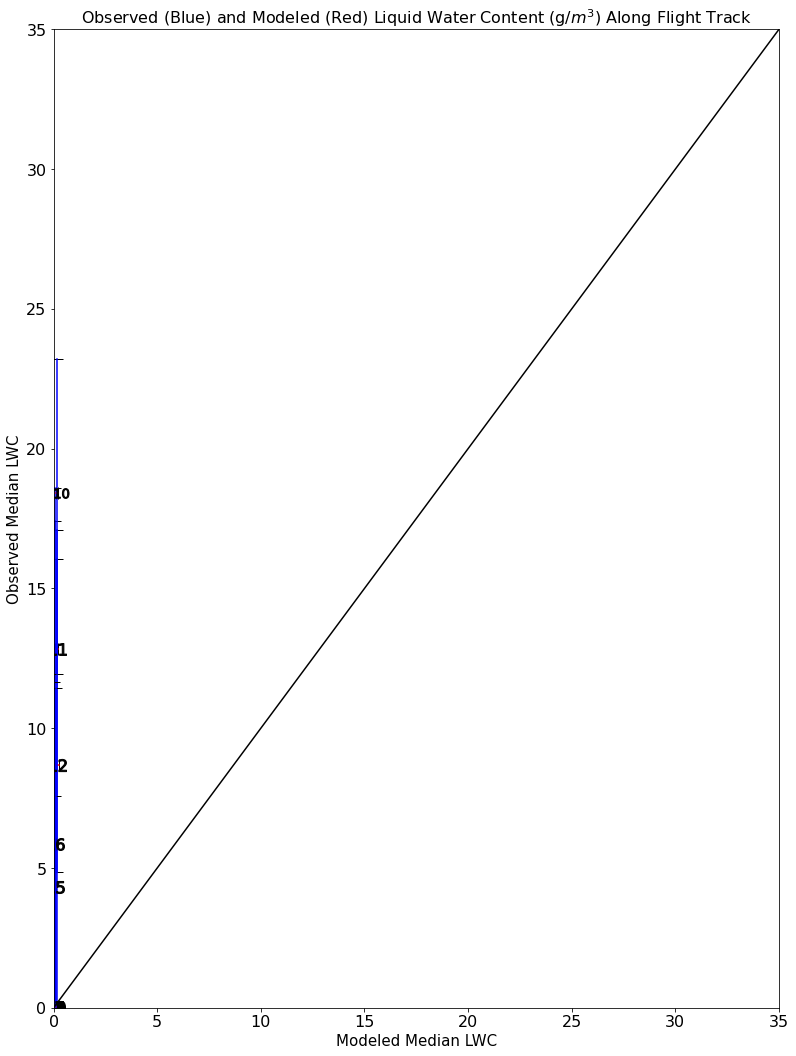

In [28]:
fig, ax = plt.subplots()
plt.plot(l1_m_75,l1_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l1_m_25,l1_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l1_m_median, l1_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l1_m_median,l1_p_75,'_',markersize = 12, color = 'black') 
x_values = [l1_m_25,l1_m_75]
y_values = [l1_p_median,l1_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l1_p_25,l1_p_75]
x_values = [l1_m_median,l1_m_median]
plt.plot(x_values, y_values, color = 'blue')

#leg2
plt.plot(l2_m_75,l2_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l2_m_25,l2_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l2_m_median, l2_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l2_m_median,l2_p_75,'_',markersize = 12, color = 'black')  
x_values = [l2_m_25,l2_m_75]
y_values = [l2_p_median,l2_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l2_p_25,l2_p_75]
x_values = [l2_m_median,l2_m_median]
plt.plot(x_values, y_values, color = 'blue')

#leg 3
# plt.plot(l3_m_75,l3_p_median,marker='|', markersize = 12, color = 'black') 
# plt.plot(l3_m_25,l3_p_median,'|', markersize = 12, color = 'black') 
# plt.plot(l3_m_median, l3_p_25,'_',markersize = 12, color = 'black') 
# plt.plot(l3_m_median,l3_p_75,'_',markersize = 12, color = 'black') 
# x_values = [l3_m_25,l3_m_75]
# y_values = [l3_p_median,l3_p_median]
# plt.plot(x_values, y_values, color = 'r')
# y_values = [l3_p_25,l3_p_75]
# x_values = [l3_m_median,l3_m_median]
# plt.plot(x_values, y_values, color = 'blue')
# print(model_lwc_L3list)
# print(plane_lwc_L3list)
#Leg 4
plt.plot(l4_m_75,l4_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l4_m_25,l4_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l4_m_median, l4_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l4_m_median,l4_p_75,'_',markersize = 12, color = 'black') 
x_values = [l4_m_25,l4_m_75]
y_values = [l4_p_median,l4_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l4_p_25,l4_p_75]
x_values = [l4_m_median,l4_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 5
plt.plot(l5_m_75,l5_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l5_m_25,l5_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l5_m_median, l5_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l5_m_median,l5_p_75,'_',markersize = 12, color = 'black') 
x_values = [l5_m_25,l5_m_75]
y_values = [l5_p_median,l5_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l5_p_25,l5_p_75]
x_values = [l5_m_median,l5_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 6
plt.plot(l6_m_75,l6_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l6_m_25,l6_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l6_m_median, l6_p_25,'_',markersize = 12, color = 'black')
plt.plot(l6_m_median,l6_p_75,'_',markersize = 12, color = 'black') 
x_values = [l6_m_25,l6_m_75]
y_values = [l6_p_median,l6_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l6_p_25,l6_p_75]
x_values = [l6_m_median,l6_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 7
plt.plot(l7_m_75,l7_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l7_m_25,l7_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l7_m_median, l7_p_25,'_',markersize = 12, color = 'black')
plt.plot(l7_m_median,l7_p_75,'_',markersize = 12, color = 'black')
x_values = [l7_m_25,l7_m_75]
y_values = [l7_p_median,l7_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l7_p_25,l7_p_75]
x_values = [l7_m_median,l7_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 8
plt.plot(l8_m_75,l8_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l8_m_25,l8_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l8_m_median, l8_p_25,'_',markersize = 12, color = 'black')
plt.plot(l8_m_median,l8_p_75,'_',markersize = 12, color = 'black') 
x_values = [l8_m_25,l8_m_75]
y_values = [l8_p_median,l8_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l8_p_25,l8_p_75]
x_values = [l8_m_median,l8_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 9
plt.plot(l9_m_75,l9_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l9_m_25,l9_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l9_m_median, l9_p_25,'_',markersize = 12, color = 'black')
plt.plot(l9_m_median,l9_p_75,'_',markersize = 12, color = 'black')
x_values = [l9_m_25,l9_m_75]
y_values = [l9_p_median,l9_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l9_p_25,l9_p_75]
x_values = [l9_m_median,l9_m_median]
plt.plot(x_values, y_values, color = 'blue')

#Leg 10
plt.plot(l10_m_75,l10_p_median,marker='|', markersize = 12, color = 'black') 
plt.plot(l10_m_25,l10_p_median,'|', markersize = 12, color = 'black') 
plt.plot(l10_m_median, l10_p_25,'_',markersize = 12, color = 'black') 
plt.plot(l10_m_median,l10_p_75,'_',markersize = 12, color = 'black') 
x_values = [l10_m_25,l10_m_75]
y_values = [l10_p_median,l10_p_median]
plt.plot(x_values, y_values, color = 'r')
y_values = [l10_p_25,l10_p_75]
x_values = [l10_m_median,l10_m_median]
plt.plot(x_values, y_values, color = 'blue')
plt.plot(l1_m_median,l1_p_median,marker = '$L1$', color = 'Black',markersize = 18)
plt.plot(l2_m_median,l2_p_median,marker = '$L2$', color = 'Black',markersize = 18)
#plt.plot(l3_m_median,l3_p_median,marker = '$L3$', color = 'Black',markersize = 18)
plt.plot(l4_m_median,l4_p_median,marker = '$L4$', color = 'black',markersize = 18)
plt.plot(l5_m_median,l5_p_median,marker = '$L5$', color = 'Black',markersize = 18)
plt.plot(l6_m_median,l6_p_median,marker = '$L6$', color = 'Black',markersize = 18)
plt.plot(l7_m_median,l7_p_median,marker = '$L7$', color = 'Black',markersize = 18)
plt.plot(l8_m_median,l8_p_median,marker = '$L8$', color = 'Black',markersize = 18)
plt.plot(l9_m_median,l9_p_median,marker = '$L9$', color = 'Black',markersize = 18)
plt.plot(l10_m_median,l10_p_median,marker = '$L10$', color = 'Black',markersize = 23)
y_values = [0,35]
x_values = [0,35]
plt.plot(x_values, y_values, color = 'black')
plt.title("Observed (Blue) and Modeled (Red) Liquid Water Content (g/$m^3$) Along Flight Track", fontsize = 16)
fig.set_size_inches(13,18)
ax.set_xticks([0,5,10,15,20,25,30,35])
ax.set_yticks([0,5,10,15,20,25,30,35])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("Modeled Median LWC", fontsize = 15)
plt.ylabel("Observed Median LWC",fontsize = 15)
plt.ylim(0,35)
plt.xlim(0,35)
plt.show()
fig.savefig("LWC_Legs_11_22_averaged", dpi = 1500)

In [29]:
#refine obs
final_obs = []
final_mod = []
final_std = []
i = 0
while i < len(total_obs):
    ob = total_obs[i]
    mod = total_model[i]
    std = obs_std[i]
    if ob >= 0.01 and mod >=0.01:
        final_obs.append(ob)
        final_mod.append(mod)
        final_std.append(std)
    i = i + 1

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


In [30]:
print(len(final_obs))

186


In [31]:
print(len(final_mod))

186


In [32]:
print(len(final_std))

186


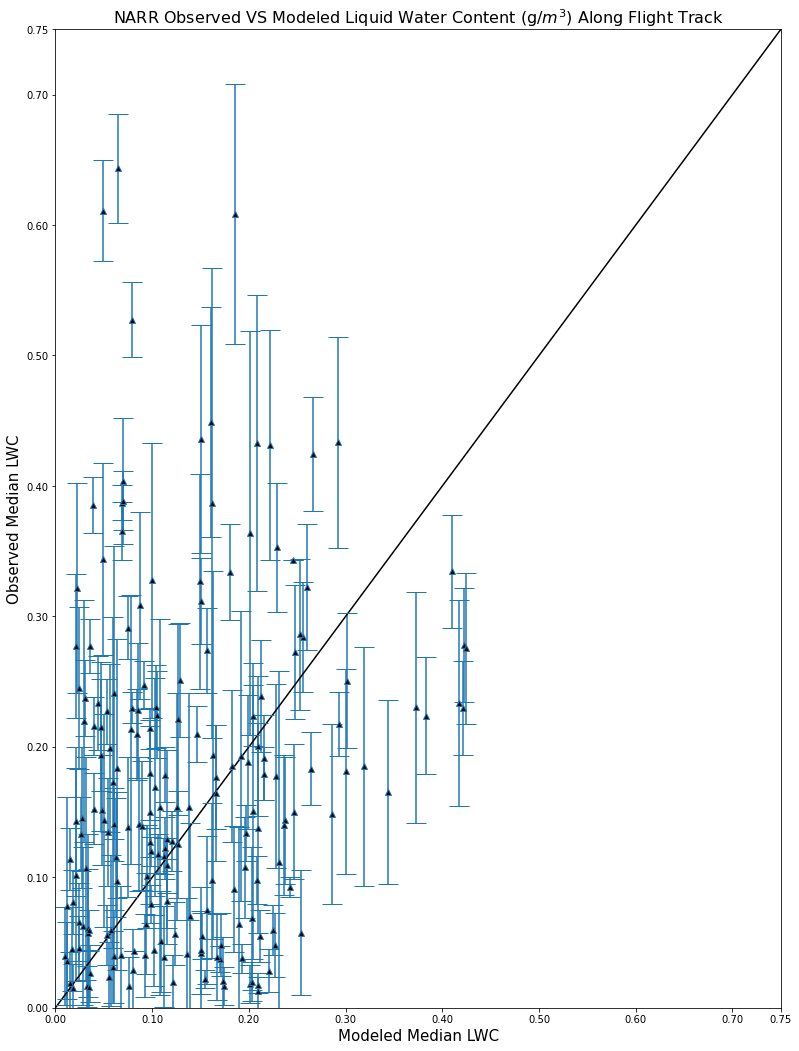

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
y_values = [0,0.75]
x_values = [0,0.75]
plt.plot(x_values, y_values, color = 'black')
#plt.scatter(final_mod,final_obs)
plt.errorbar(final_mod,final_obs, final_std, linestyle = 'None', marker = '^', markerfacecolor = "Black", capsize = 10)
ax.set_xticks([0,.1,.2,.3,.4,.5,.6,.7,.75])
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.75])
plt.xlabel("Modeled Median LWC", fontsize = 15)
plt.ylabel("Observed Median LWC",fontsize = 15)
plt.title("NARR Observed VS Modeled Liquid Water Content (g/$m^3$) Along Flight Track", fontsize = 16)
plt.ylim(0,.75)
plt.xlim(0,.75)
fig.set_size_inches(13,18)
plt.show()
fig.savefig("NARR_LWC_Grids_FT", dpi = 1500)

In [34]:
obs_median= statistics.median(final_obs)
obs_75 = np.percentile(final_obs, 75)
obs_25 = np.percentile(final_obs, 25)
model_median= statistics.median(final_mod)
model_75 = np.percentile(final_mod, 75)
model_25 = np.percentile(final_mod, 25)
print(obs_median)
print(obs_75)
print(obs_25)
print("*")
print(model_median)
print(model_75)
print(model_25)

0.14930236339569092
0.2305145561695099
0.061616936698555946
*
0.11430992931127548
0.20237434655427933
0.060344379395246506


{'whiskers': [<matplotlib.lines.Line2D at 0x2aad3ddcf0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2aad3ddcf950>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aad3ddc6c90>,
 'medians': [<matplotlib.lines.Line2D at 0x2aad3ddda250>,
 'fliers': [<matplotlib.lines.Line2D at 0x2aad3ddda690>,
 'means': []}

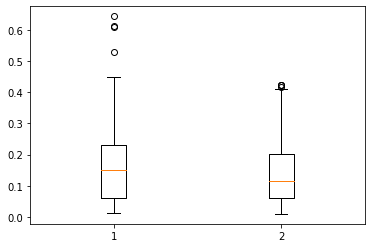

In [35]:
import numpy as np
import matplotlib.pyplot as plt
data = [final_obs, final_mod]
fig1, ax1 = plt.subplots()
ax1.boxplot(data)

In [36]:
f = open("test.csv","w", newline = "")
writer = csv.writer(f)
writer.writerow(str(i))
f.close()

In [42]:
import csv
f = open('ERA5_LWC.csv','w')
writer = csv.writer(f)
for i in total_model:
    writer.writerow([str(i)])

f = open('ERA5_LWC.csv','r')
testy = []
for line in f:
    testy.append(float(line))

In [ ]:
CDNC_obs

In [70]:
print(len(total_model))
print(len(total_obs))

377
377


In [45]:
import csv
f = open('LWC_obs.csv','w')
writer = csv.writer(f)
for i in total_obs:
    writer.writerow([str(i)])